In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4,7'

In [2]:
from src.ModelTransfuser import ModelTransfuser as MTf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch

from scipy.stats import norm, gaussian_kde
from scipy import optimize

import os

%matplotlib inline

# Load data

In [3]:
data_model = "842"

In [4]:
# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y

In [5]:
# ---  Load in the validation data ---
path_test = os.getcwd() + f'/data/Chempy_model_comp_data/chempy_{data_model}_val.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']

val_x, val_y = clean_data(val_x, val_y)

# convert to torch tensors
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

# --- add noise ---
pc_ab = 5 # percentage error in abundance

val_y_err = torch.ones_like(val_y)*float(pc_ab)/100.
val_y = norm.rvs(loc=val_y,scale=val_y_err)
val_y = torch.tensor(val_y).float()

val_data = torch.cat((val_x, val_y), 1)

## Define ModelTransfuser

In [6]:
# Define the ModelTransfuser
model_442 = MTf.load('data/models/chempy_442/Model_checkpoint.pt')
model_742 = MTf.load('data/models/chempy_742/Model_checkpoint.pt')
model_842 = MTf.load('data/models/chempy_842/Model_checkpoint.pt')

## Sampling

In [7]:
posterior_mask = torch.zeros_like(val_data[0])
posterior_mask[6:] = 1

data = val_data[:1000, posterior_mask.type(torch.bool)]

In [8]:
posterior_442 = model_442.sample(data, condition_mask=posterior_mask, device="cuda", timesteps=100, cfg_alpha=None, save_trajectory=True, corrector_steps=5, corrector_steps_interval=5, final_corrector_steps=10).to("cpu")
posterior_742 = model_742.sample(data, condition_mask=posterior_mask, device="cuda", timesteps=100, cfg_alpha=None, save_trajectory=True, corrector_steps=5, corrector_steps_interval=5, final_corrector_steps=10).to("cpu")
posterior_842 = model_842.sample(data, condition_mask=posterior_mask, device="cuda", timesteps=100, cfg_alpha=None, save_trajectory=True, corrector_steps=5, corrector_steps_interval=5, final_corrector_steps=10).to("cpu")

100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


In [10]:
theta_hat_442 = posterior_442.mean(dim=1)[:,:6]
theta_hat_742 = posterior_742.mean(dim=1)[:,:6]
theta_hat_842 = posterior_842.mean(dim=1)[:,:6]

In [12]:
likelihood_mask = torch.zeros_like(val_data[0])
likelihood_mask[:6] = 1

In [13]:
likelihood_442 = model_442.sample(theta_hat_442, condition_mask=likelihood_mask, device="cuda", timesteps=100, cfg_alpha=None, save_trajectory=True, corrector_steps=5, corrector_steps_interval=5, final_corrector_steps=10).to("cpu")
likelihood_742 = model_742.sample(theta_hat_742, condition_mask=likelihood_mask, device="cuda", timesteps=100, cfg_alpha=None, save_trajectory=True, corrector_steps=5, corrector_steps_interval=5, final_corrector_steps=10).to("cpu")
likelihood_842 = model_842.sample(theta_hat_842, condition_mask=likelihood_mask, device="cuda", timesteps=100, cfg_alpha=None, save_trajectory=True, corrector_steps=5, corrector_steps_interval=5, final_corrector_steps=10).to("cpu")

100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


In [14]:
x_hat_442 = likelihood_442.mean(dim=1)[:,6:]
x_hat_742 = likelihood_742.mean(dim=1)[:,6:]
x_hat_842 = likelihood_842.mean(dim=1)[:,6:]

In [15]:
def log_prob(samples, x):
    kde = gaussian_kde(samples.T.numpy())
    return kde.logpdf(x).item()

In [21]:
log_probs_442 = np.array([log_prob(likelihood_442[i,:,6:], data[i]) for i in range(len(data))])
log_probs_742 = np.array([log_prob(likelihood_742[i,:,6:], data[i]) for i in range(len(data))])
log_probs_842 = np.array([log_prob(likelihood_842[i,:,6:], data[i]) for i in range(len(data))])

In [25]:
print(f"Log Prob model 442: {log_probs_442.sum():.2f}")
print(f"Log Prob model 742: {log_probs_742.sum():.2f}")
print(f"Log Prob model 842: {log_probs_842.sum():.2f}")

Log Prob model 442: 5605.20
Log Prob model 742: -446.77
Log Prob model 842: 7059.38


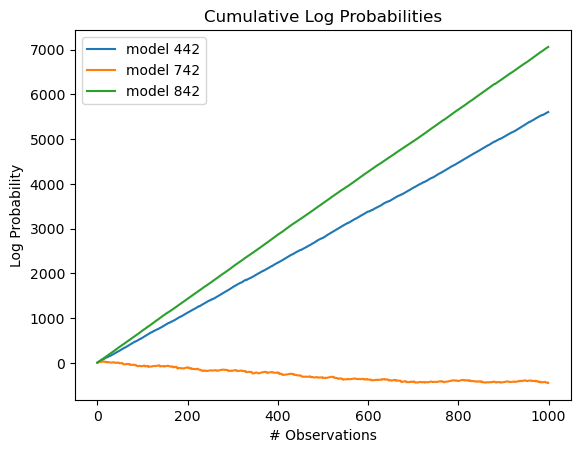

In [34]:
plt.plot(np.cumsum(log_probs_442), label="model 442")
plt.plot(np.cumsum(log_probs_742), label="model 742")
plt.plot(np.cumsum(log_probs_842), label="model 842")

plt.title("Cumulative Log Probabilities")
plt.xlabel("# Observations")
plt.ylabel("Log Probability")
plt.legend()
plt.show()